# ML Models
---

## Libraries

In [68]:
import pandas as pd
import numpy as np

import warnings 
warnings.filterwarnings("ignore")

import re

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(palette="muted")

from sklearn.model_selection import train_test_split 
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve


import matplotlib.pyplot as plt


from scipy.stats import bootstrap

---
## Load data

In [69]:
df = pd.read_csv('..\\datasets\\2. Processed Dataset\\result.csv')
df = df.drop(columns=["id"], errors="ignore")

---
## Model training

In [70]:
# Split of the dataset into features and target
X = df.drop('Salary',axis=1) 
y = df['Salary'] 

# Split data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=0) # 25% test

# Initialize and train models
models = {
    "Dummy": DummyRegressor(strategy="mean"),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=0),
    "Linear Regression": LinearRegression(),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=0)
}

for name, model in models.items():
    model.fit(X_train, y_train)

# Compute metrics
def compute_metrics(y_true, y_pred, model_name):
    print(f"{model_name} -> MAE: {mean_absolute_error(y_true, y_pred):.2f}, "
          f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}, "
          f"R²: {r2_score(y_true, y_pred):.2f}")

# Make predictions and evaluate
for name, model in models.items():
    y_pred = model.predict(X_test)
    compute_metrics(y_test, y_pred, name)

Dummy -> MAE: 40690.51, RMSE: 48180.83, R²: -0.00
Random Forest -> MAE: 8112.01, RMSE: 13399.45, R²: 0.92
Linear Regression -> MAE: 9676.66, RMSE: 13160.04, R²: 0.93
XGBoost -> MAE: 7577.01, RMSE: 11898.00, R²: 0.94


### Model Hyperparameter Tunning with Grid Search

In [71]:
# Split of the dataset into features and target
X = df.drop('Salary',axis=1) 
y = df['Salary'] 

# Split data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=0) # 25% test

# Hyperparameter grids
param_grids = {
    "Random Forest": {
        "n_estimators": [100, 200, 300],
        "max_depth": [2, 4, 8, 10, 20, None],
        "min_samples_split": [1, 2, 5, 10, 20]
    },
    "Linear Regression": {},  # Has not hyperparameters
    "XGBoost": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 6, 10]
    }
}

# Initialize models
models = {
    "Dummy": DummyRegressor(strategy="mean"),
    "Random Forest": RandomForestRegressor(random_state=0),
    "Linear Regression": LinearRegression(),
    "XGBoost": XGBRegressor(random_state=0)
}

# Train models with hyperparameter tuning
best_models = {}
for name, model in models.items():
    if name in param_grids:  # If hyperparameters exist, apply GridSearchCV
        search = GridSearchCV(model, param_grids[name], cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
        search.fit(X_train, y_train)
        best_models[name] = search.best_estimator_
        print(f"Best params for {name}: {search.best_params_}")
    else:  # For Dummy and Linear Regression (no tuning)
        model.fit(X_train, y_train)
        best_models[name] = model

# Compute metrics
def compute_metrics(y_true, y_pred, model_name):
    print(f"{model_name} -> MAE: {mean_absolute_error(y_true, y_pred):.2f}, "
          f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}, "
          f"R²: {r2_score(y_true, y_pred):.2f}")

# Make predictions and evaluate
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    compute_metrics(y_test, y_pred, name)

Best params for Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Best params for Linear Regression: {}
Best params for XGBoost: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50}
Dummy -> MAE: 40690.51, RMSE: 48180.83, R²: -0.00
Random Forest -> MAE: 8077.62, RMSE: 13333.79, R²: 0.92
Linear Regression -> MAE: 9676.66, RMSE: 13160.04, R²: 0.93
XGBoost -> MAE: 7168.80, RMSE: 10622.92, R²: 0.95


---
## Overfitting Evaluation

### Compare Training vs. Test Performance

In [72]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print(f"{model_name} Performance:")
    print(f"Train R²: {train_r2:.2f} | Test R²: {test_r2:.2f}")
    print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.2f} | Test RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.2f}")
    print("-" * 50)

# Apply this function to all trained models
for name, model in best_models.items():
    evaluate_model(model, X_train, y_train, X_test, y_test, name)

Dummy Performance:
Train R²: 0.00 | Test R²: -0.00
Train RMSE: 48450.91 | Test RMSE: 48180.83
--------------------------------------------------
Random Forest Performance:
Train R²: 0.99 | Test R²: 0.92
Train RMSE: 4995.62 | Test RMSE: 13333.79
--------------------------------------------------
Linear Regression Performance:
Train R²: 0.92 | Test R²: 0.93
Train RMSE: 13607.86 | Test RMSE: 13160.04
--------------------------------------------------
XGBoost Performance:
Train R²: 0.97 | Test R²: 0.95
Train RMSE: 7869.62 | Test RMSE: 10622.92
--------------------------------------------------


### Cross-Validation

In [73]:
def cross_validate_model(model, X, y, cv=5):
    scores = cross_val_score(model, X, y, cv=cv, scoring='r2', n_jobs=-1)
    print(f"Cross-Validation R²: {scores.mean():.2f} ± {scores.std():.2f}")

# Apply on best models
for name, model in best_models.items():
    print(f"{name} Cross-Validation:")
    cross_validate_model(model, X, y)
    print("-" * 50)

Dummy Cross-Validation:
Cross-Validation R²: -0.01 ± 0.01
--------------------------------------------------
Random Forest Cross-Validation:
Cross-Validation R²: 0.91 ± 0.06
--------------------------------------------------
Linear Regression Cross-Validation:
Cross-Validation R²: 0.90 ± 0.06
--------------------------------------------------
XGBoost Cross-Validation:
Cross-Validation R²: 0.91 ± 0.06
--------------------------------------------------


### Conclutions
- Random Forest: 
    - Train R²: 0.99 | Test R²: 0.92 - R2 Train is much grater than Test R2, its overfitting.
    - Train RMSE (4995.62) vs Test RMSE (13333.79) - Large gap suggests overfitting

- Linear Regression
    - Train R²: 0.92 | Test R²: 0.93 - Train and Test R² are close what suggest is doing a good generalization.
    - RMSE values are also close → No large performance drop.
    - Cross-validation confirms stability (0.90 ± 0.06).
    
- XGBoost
    - Train R²: 0.97 | Test R²: 0.95 and Train RMSE: 7869.62 | Test RMSE: 10622.92- There is some overfitting.
    - Cross-validation is stable (0.91 ± 0.06)

- Random Forest:
    - min_samples_split
        - Best fit was 2 for "min_samples_split": [1, 2, 5, 10, 20]
        - For low values of min_samples_split (left side, near 2-10), the model shows overfitting.
        - Increasing min_samples_split (moving right, 20-50) both scores decrease gradually.The gap between training and validation scores narrows, which means the model is becoming less overfitted and generalizing better.
        - For high values of min_samples_split (above 50) the model starts to underfit, training and validation score also drop meaning the model is not complex enough to capture important patterns in the data.
        - The optimal range of min_samples_split is between 10 and 30 seems to be a good choice since it balances training and validation performance.
    - max_depth
        - Best fit was 20 for "max_depth": [2, 4, 8, 10, 20, None]
        - For small max_depth (1-5) both training (blue) and validation (red) scores increase steeply. At max_depth = 5, the model reaches high validation performance (~0.92). This suggests that with a low max_depth, the model was underfitting but quickly improved as depth increased.
        - For larger max_depth (5-15) training score continues increasing and approaches 1.0 (perfect fit). Validation score plateaus around 0.92-0.93, indicating that further increases in depth do not improve generalization.
        - For very high max_depth (>15) training score remains at 1.0, showing that the model is memorizing the training data (overfitting). Validation score stays constant (~0.92), meaning deeper trees do not improve performance. The widening gap between training and validation scores suggests increasing overfitting.
        - The optimal range for max_depth is between 5-10.
    

- XGBoost:
Best params for Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Best params for Linear Regression: {}
Best params for XGBoost: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50}
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 6, 10]

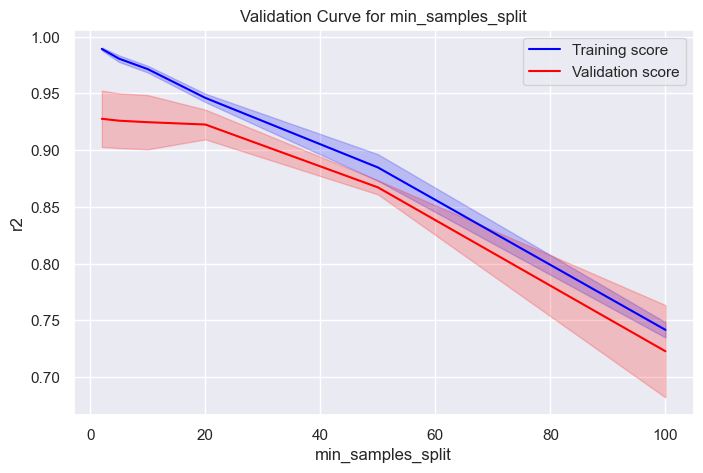

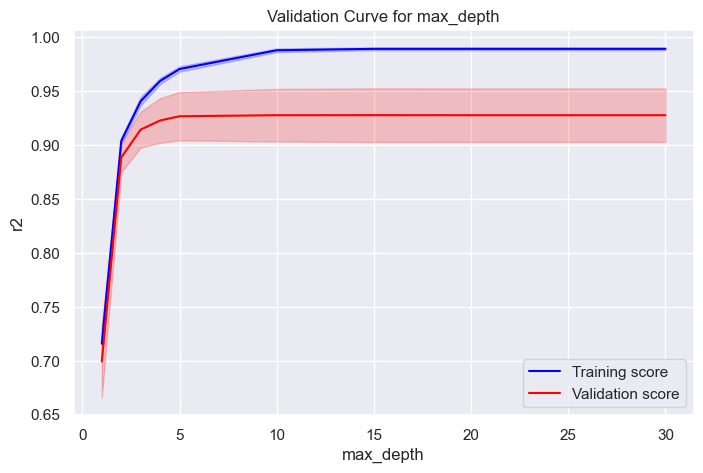

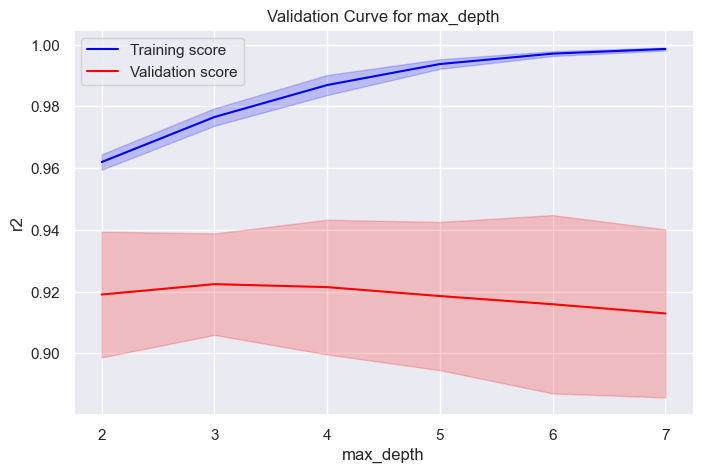

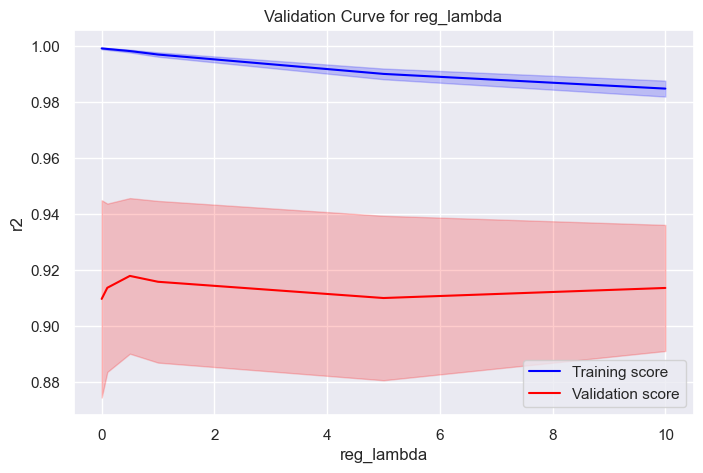

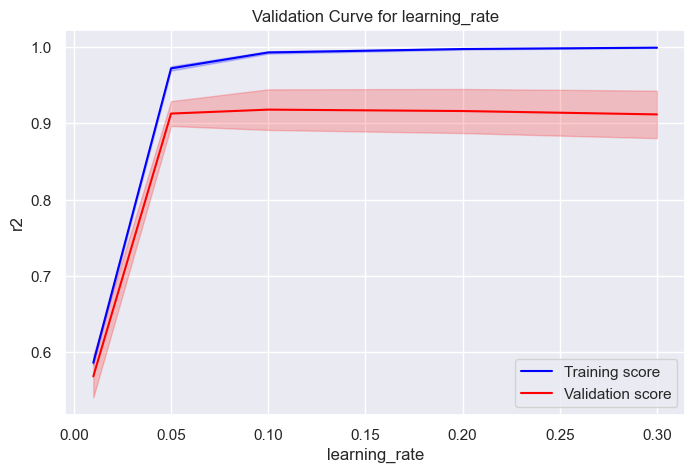

In [74]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Function to plot validation curves
def plot_validation_curve(estimator, param_name, param_range, X_train, y_train, scoring='r2'):
    train_scores, test_scores = validation_curve(
        estimator, X_train, y_train, param_name=param_name, param_range=param_range,
        cv=5, scoring=scoring, n_jobs=-1
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(param_range, train_mean, label="Training score", color="blue")
    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")
    plt.plot(param_range, test_mean, label="Validation score", color="red")
    plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.2, color="red")
    
    plt.xlabel(param_name)
    plt.ylabel(scoring)
    plt.title(f"Validation Curve for {param_name}")
    plt.legend()
    plt.show()

# ------------------ RANDOM FOREST ------------------
# Tuning min_samples_split - Increasing to reduce overfitting - Best fit was 2 for "min_samples_split": [1, 2, 5, 10, 20]
rf_model = RandomForestRegressor(n_estimators=200, random_state=0)
param_range = [2, 5, 10, 20, 50, 100]
plot_validation_curve(rf_model, 'min_samples_split', param_range, X_train, y_train)

# Tuning max_depth (Reducing to avoid overfitting)  - Best fit was 20 for "max_depth": [2, 4, 8, 10, 20, None]
param_range = [1, 2, 3, 4, 5, 10, 15, 20, 30]
plot_validation_curve(rf_model, 'max_depth', param_range, X_train, y_train)

# ------------------ XGBOOST ------------------
# Tuning max_depth (Reducing overfitting)
xgb_model = XGBRegressor(n_estimators=50, learning_rate=0.2, random_state=0)
param_range = [2, 3, 4, 5, 6, 7]
plot_validation_curve(xgb_model, 'max_depth', param_range, X_train, y_train)

# Tuning lambda (L2 Regularization, Increasing to reduce overfitting)
param_range = [0, 0.1, 0.5, 1, 5, 10]
plot_validation_curve(xgb_model, 'reg_lambda', param_range, X_train, y_train)

# Tuning learning_rate (Reducing to avoid high variance)
param_range = [0.01, 0.05, 0.1, 0.2, 0.3]
plot_validation_curve(xgb_model, 'learning_rate', param_range, X_train, y_train)

In [76]:
# Define a simple feedforward neural network
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Predictions
y_pred_nn = model.predict(X_test).flatten()

print(f"Keras -> MAE: {mean_absolute_error(y_pred_nn, y_pred):.2f}, "
        f"RMSE: {np.sqrt(mean_squared_error(y_pred_nn, y_pred)):.2f}, "
        f"R²: {r2_score(y_pred_nn, y_pred):.2f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Keras -> MAE: 92780.63, RMSE: 102637.89, R²: -2966.01


In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

In [ ]:
# Confidence Intervals
boot_metrics = {"MAE": [], "RMSE": [], "R2": []}
num_bootstrap = 1000

for _ in range(num_bootstrap):
    indices = np.random.choice(len(y_test), size=len(y_test), replace=True)
    y_test_sample = y_test.iloc[indices]
    y_pred_sample = y_pred_rf[indices]
    metrics = compute_metrics(y_test_sample, y_pred_sample)
    for key in boot_metrics:
        boot_metrics[key].append(metrics[key])

ci_95 = {metric: (np.percentile(values, 2.5), np.percentile(values, 97.5)) for metric, values in boot_metrics.items()}

# Print results
print("Dummy Model:", results_dummy)
print("Random Forest Model:", results_rf)
print("95% Confidence Intervals:", ci_95)

Dummy Model: {'MAE': 40690.50882167612, 'RMSE': 48180.83218379831, 'R2': -0.00029651269527053437}
Random Forest Model: {'MAE': 8187.810127674259, 'RMSE': 13129.306241630149, 'R2': 0.9257213986110274}
95% Confidence Intervals: {'MAE': (6309.50532694962, 10553.800724637682), 'RMSE': (9490.532520796181, 16744.374987512587), 'R2': (0.8704464400847671, 0.9602581561171868)}


In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, scoring='neg_mean_absolute_error', cv=3)
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")

best_rf = grid_search.best_estimator_